In [2]:
!pip install netcdf4
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import time


## Preparing Traning DATA

In [3]:
# generate Gaussian distribution
def PDF(x,mu,std):
    return stats.norm(mu, std).pdf(x)


0.9980707063385575
0.996178478110691
0.9943390251006088
0.9925749793264045
0.9909181775146972
0.9894119341232606
0.9881127135842722
0.9870905066492603
0.9864274324876559
0.9862146484726808


Text(0, 0.5, 'Final position')

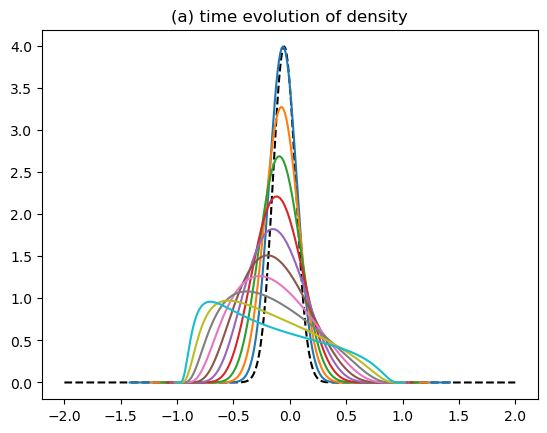

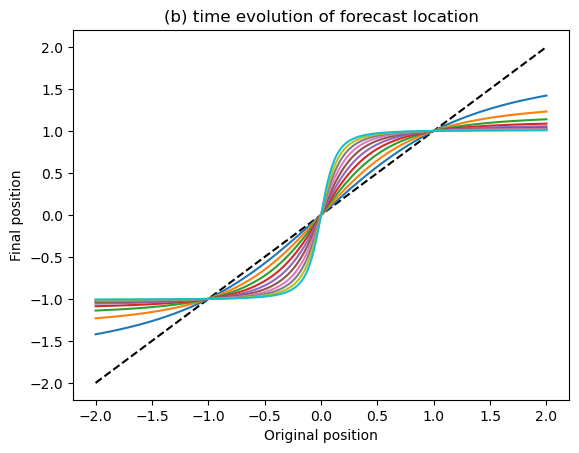

In [4]:
#  analytical solution (using final state to find the initial state)
def xi(x,t):
    xi = x*np.exp(-t)*(1-x**2+x**2*np.exp(-2*t))**(-1/2)
    return xi

t    = 0.2
plt.figure()
x_0  = np.arange(-2,2.01,0.01)
x    = np.arange(-2,2.01,0.01)
x_analytic = np.zeros((100,np.size(x)))

x_ref  = np.arange(-2,2.01,0.01)
rho  = PDF(x,-0.05,0.1)
xint = 0
plt.figure(1)
plt.plot(x,rho,'k--')
plt.figure(2)
plt.plot(x_ref,x_ref,'k--')

for count in range(10):
    x_0  = x
    x_analytic[count,:] = x
    xint = 0
    for i in np.arange(0,100,1): # for each integration, we divide the data into 1/window is the integration step
        tp = i/(100)*t
        x  = x_0*np.exp(tp)*(1-x_0*x_0+x_0*x_0*np.exp(2*tp))**(-1/2)
        c  = 1-3*x*x
        xint += c
    plt.figure(1)
    plt.plot(x,rho)
    plt.title('(a) time evolution of density')
    rho  = rho*np.exp(-xint*t/100)
    rho  = rho
    result = np.trapz(rho,x)
    plt.figure(2)
    #plt.plot(x,rho/result)
    plt.plot(x_ref,x)
    plt.title('(b) time evolution of forecast location')
    #result = np.trapz(rho/result,x)
    print(result)
plt.xlabel('Original position')
plt.ylabel('Final position')


In [5]:
# using RK4 to derive the data for training
# function to be solved
def f(y):
    return y-np.power(y,3)

# or
# f = lambda x: x+y

# RK-4 method
def rk4(x0,y0,xn,n):

    # Calculating step size
    h = (xn-x0)/n

    # print('\n--------SOLUTION--------')
    # print('-------------------------')
    # print('x0\ty0\tyn')
    # print('-------------------------')
    for i in range(n+1):
        k1 = h * (f(y0))
        k2 = h * (f((y0+k1/2)))
        k3 = h * (f((y0+k2/2)))
        k4 = h * (f((y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
    return yn
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

Enter initial conditions:
Enter calculation point: (the length of each increment)
Enter number of steps in eachc increment


Text(0, 0.5, 'Final position')

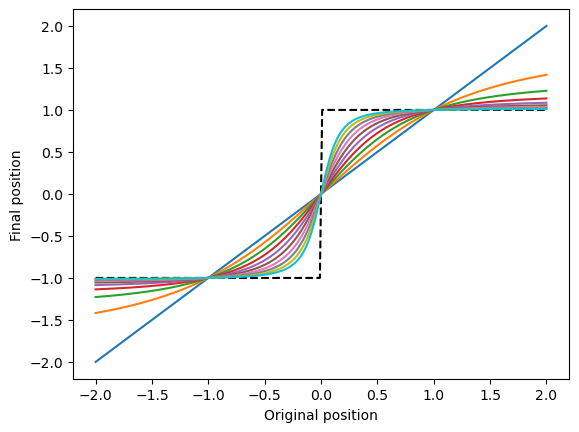

In [6]:
# using RK4 to generate training data
# Inputs
print('Enter initial conditions:')
t0     = 0
x0_RK4 = np.arange(-2,2.01,0.01)

print('Enter calculation point: (the length of each increment)')
tn   = 0.2

print('Enter number of steps in eachc increment')
step = 1000

x_RK4      = np.zeros((100,np.size(x0_RK4)))
x_RK4[0,:] = x0_RK4
for i in range(100-1):
    x_RK4[i+1,:] = rk4(t0,x0_RK4,tn,step)
    x0_RK4       = x_RK4[i+1,:]
    
# plot the time evolution of training data
plt.figure()
plt.plot(x_RK4[0,:],x0_RK4,'k--')
for i in range(10):
    plt.plot(x_RK4[0,:],x_RK4[i,:])
plt.xlabel('Original position')
plt.ylabel('Final position')

## Devlop a DNN for solving the Bernoulli ODE

In [1]:
# import DNN environment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, InputLayer, Activation, Input
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import History
import time


In [12]:
# define function for monitoring
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# define function for deep learing model
def defineNN(hidden, input_shape, output_shape, lassoPenalty=0., ridgePenalty = 0.):

    model  = Sequential()
    actFun = 'relu'
    #actFun = 'sigmoid'

    # initialize first layer
    if hidden[0]==0:
        #model is linear
        model.add(Dense(2, input_shape=(input_shape,), activation='linear', use_bias=True, kernel_regularizer=regularizers.l1_l2(l1=lassoPenalty, l2=ridgePenalty),bias_initializer=keras.initializers.RandomNormal(seed=random_network_seed),
                kernel_initializer=keras.initializers.RandomNormal(seed=random_network_seed)))
    else:
        #model is a single node with activation function
        model.add(Dense(hidden[0], input_shape=(input_shape,), activation=actFun, use_bias=True, kernel_regularizer=regularizers.l1_l2(l1=lassoPenalty, l2=ridgePenalty),bias_initializer=keras.initializers.RandomNormal(seed=random_network_seed),
                kernel_initializer=keras.initializers.RandomNormal(seed=random_network_seed)))

        #initialize other layers
        for layer in hidden[1:]:
            model.add(Dense(layer, activation=actFun, use_bias=True, kernel_regularizer=regularizers.l1_l2(l1=lassoPenalty, l2=ridgePenalty),bias_initializer=keras.initializers.RandomNormal(seed=random_network_seed),
                kernel_initializer=keras.initializers.RandomNormal(seed=random_network_seed)))


    #initialize output layer
    model.add(Dense(1, activation='linear', use_bias=True, kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0),bias_initializer=keras.initializers.RandomNormal(seed=random_network_seed),
                kernel_initializer=keras.initializers.RandomNormal(seed=random_network_seed)))

    # add softmax layer at the end (for probabilistic forecast only)
    #model.add(Activation('softmax'))

    return model

# compile the deep learning model
def trainNN(model, Xtrain, Ytrain, niter=500, verbose=False, validation_split=0.1):
    # for regression problem
    model.compile(optimizer= 'adam',
                  loss     = 'mean_squared_error',
                  metrics  = ['mse'],)
    # for classification problem
    #model.compile(optimizer=optimizers.SGD(momentum=0.9),
    #             loss =e 'binary_crossentropy',
    #             metrics=[metrics.categorical_accuracy],)

    #Declare the relevant model parameters
    batch_size = np.shape(Xtrain)[0] #This doesn't seem to affect much in this case


    # setup early stop to avoid overfitting
    callback = TimeHistory()
    #callback     = EarlyStopping(monitor='val_loss', mode='min', min_delta=10e-5, verbose=0,patience=1000)
    #callback     = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=500)
    #callback     = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=10)

    history       = model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=niter, shuffle=True, verbose=verbose, callbacks=[callback], validation_split=validation_split)
    #print('******** done training ***********')

    return model, history

In [13]:
# mix different time lags together
sample_size = 400 # 400 data points between x=-1 and 1 
total_lag   = 20  # the total step of integration (non-dimension time)
predictor   = np.zeros((1,sample_size,total_lag))
predictand  = np.zeros((1,sample_size,total_lag))

# rearrange data for traning (randomly sampled)
for lag in range(total_lag):
    posi                = np.random.choice(401, sample_size)
    predictor[0,:,lag]  = x_RK4[lag,posi].T
    predictand[0,:,lag] = x_RK4[lag+1,posi].T
predictor         = np.reshape(predictor,[1,sample_size*total_lag])
predictand        = np.reshape(predictand,[1,sample_size*total_lag])


2024-02-19 17:20:38.022278: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


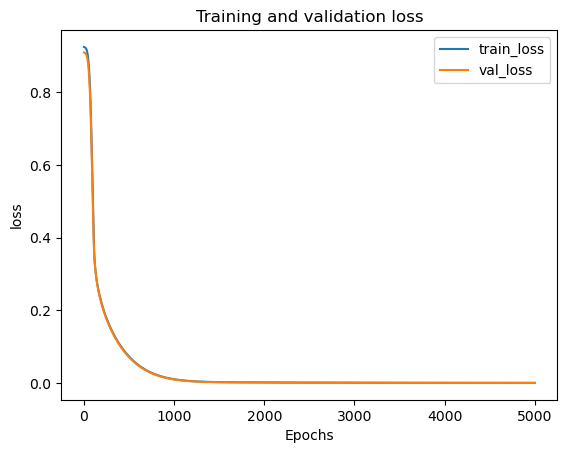

In [14]:
# Develop DNN
# mix different time lags together
keras.backend.clear_session()
################## MODEL SPECIFICS ########################
random_network_seed     = 3                 # model id
niter                   = 5000              # times of iteration
#layersNodes             = [3,]             # linear model setup    = one input layer (3 variables),
layersNodes             = [10,10,10]        # nonlinear model setup = one input layer (2 variables), 3 neurons in the first hidden layer and 3 neurons in the second hidden layer
###########################################################

# define deep learning model
model = defineNN(layersNodes, input_shape = np.shape(np.transpose(predictor))[1], output_shape = np.shape(np.transpose(predictand))[1],lassoPenalty=0.000001, ridgePenalty=0)

# start training !!!
model, history = trainNN(model, np.transpose(predictor), np.transpose(predictand), niter=niter, verbose=0, validation_split=0.1)

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')

13/13 [==============================] - 0s 376us/step


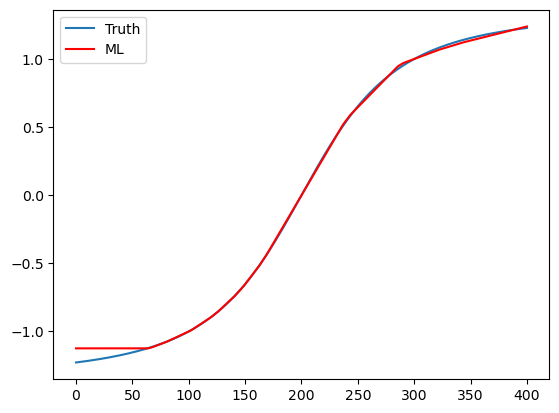

In [22]:
# using ML for prediction
predictor = np.zeros((1,401))
x_ANN     = np.zeros(np.shape(x_RK4))
x_ANN[0,:] = x_RK4[0,:]
for i in range(40):
    if i==0:
        predictor[0,:]  = x_RK4[0,:]
        x_ANN[i+1,:]    = model.predict(predictor.T).T
    else:
        predictor[0,:]  = x_ANN[i,:]
        x_ANN[i+1,:]    = model.predict(predictor.T).T

# examine the ML-based solution 
lag = 2
plt.figure()
plt.plot(x_RK4[lag,:],label='Truth')
plt.plot(x_ANN[lag,:],'r',label='ML')
plt.legend()

## Estimate Liouville Equation 

Start here
7/7 [==============================] - 0s 404us/step


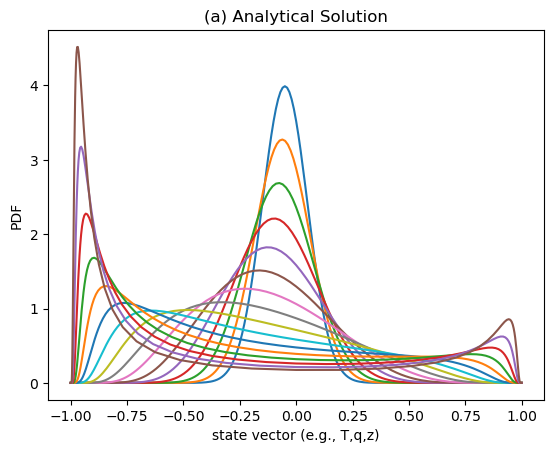

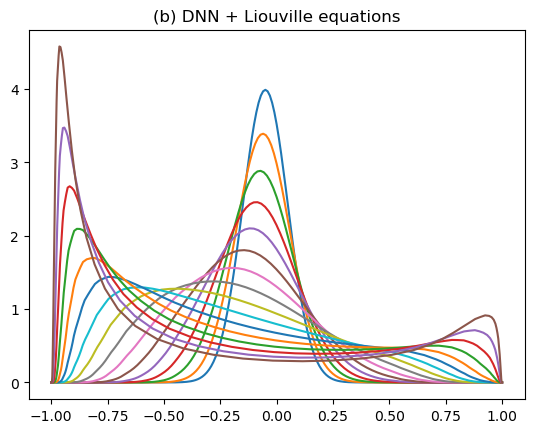

In [165]:
t    = 0.2
lag  = 15
plt.figure()
x_0    = np.arange(-1,1.01,0.01)
x      = np.arange(-1,1.01,0.01)
x_ref  = np.arange(-1,1.01,0.01)




################# analytical solution ##############################
rho             = PDF(x,-0.05,0.1)             #initial PDF
rho_analytical  = np.zeros((np.size(rho),lag)) #PDF based on analytical solution
xint            = 0                            #xint = df/dx *dt
x_analytical    = np.zeros((np.size(x),lag))
xint_analytical = np.zeros((np.size(x),lag))
plt.plot(x,rho)
for count in range(lag):
    x_0  = x
    xint = 0
    for i in np.arange(0,1000,1):
        tp = i*t/(1000)
        x  = x_0*np.exp(tp)*(1-x_0*x_0+x_0*x_0*np.exp(2*tp))**(-1/2)
        c  = 1-3*x*x
        xint += c

    det_L = np.exp(-xint*0.2/1000)
    if count == 0:
        det_L_record         = det_L 
    x_analytical[:,count]    = x
    rho  = rho*np.exp(-xint*t/1000)
    rho  = rho/np.trapz(rho,x)
    result = np.trapz(rho,x)
    rho_analytical[:,count] = rho
    plt.plot(x,rho)

    plt.title('(a) Analytical Solution')
    plt.xlabel('state vector (e.g., T,q,z)')
    plt.ylabel('PDF')


    
dx       = np.ones(np.shape(x))*(1e-4)
    
################### SINDy based approach ################################
from sklearn import linear_model
from scipy.interpolate import griddata
t     = 0.2
plt.figure()
x_0    = np.arange(-1,1.01,0.01)
x      = np.arange(-1,1.01,0.01)
x_ML   = np.zeros((np.size(x),lag))
rho    = PDF(x,-0.05,0.1)
rho_ML = np.zeros((np.size(x),lag))
plt.plot(x,rho)


print('Start here')
for count in range(lag):
    xint = 0
    x_old           = x_0
    predictor2      = np.ones((1,np.size(x)))
    predictor2[0,:] = np.squeeze(x)
    #c_init          = 1-3*x*x
    
    x               = np.reshape(model.predict(np.transpose(predictor2)),[np.size(x),])
    ##### calculate determinant #### 
    if count == 0:
        x_pdx           = np.reshape(model.predict(np.transpose(predictor2+dx)),[np.size(x),])
        x_mdx           = np.reshape(model.predict(np.transpose(predictor2-dx)),[np.size(x),])
        xint            = (x_pdx-x_mdx)/(2*dx)-1 #calculate tangent linear function: df/dx*dt
        det_ML_inv      = np.exp(-xint)
        
        x_location      = predictor2[0,:]
        # using 5th order polynomial for SINDy bias correction
        x_predictor     = np.squeeze(np.array([x_location,x_location*x_location,\
                                                    x_location*x_location*x_location,\
                                                    x_location*x_location*x_location*x_location,\
                                                    x_location*x_location*x_location*x_location*x_location]))
        
        clf                  = linear_model.Lasso(alpha=0.01)
        clf.fit(x_predictor.T, det_ML_inv)
        det_ML_inv           = clf.coef_.T.dot(x_predictor)+clf.intercept_ # corrected SINDy
    
    x_predictor     = np.squeeze(np.array([x,x*x,\
                                           x*x*x,\
                                           x*x*x*x,\
                                           x*x*x*x*x]))
    det_ML_temporal  = clf.coef_.T.dot(x_predictor)+clf.intercept_
    #det_ML_temporal  = griddata(points=x_location, values=det_ML_inv, xi=x, method='linear')   # find det at given location 
    x_0              = x
    x_ML[:,count]    = x
    rho              = rho*det_ML_temporal
    rho_ML[:,count]  = rho/np.trapz(rho,x)
    plt.plot(x,rho.T)
    plt.title('(b) DNN + Liouville equations')    #plt.plot(x_ref,x)
    


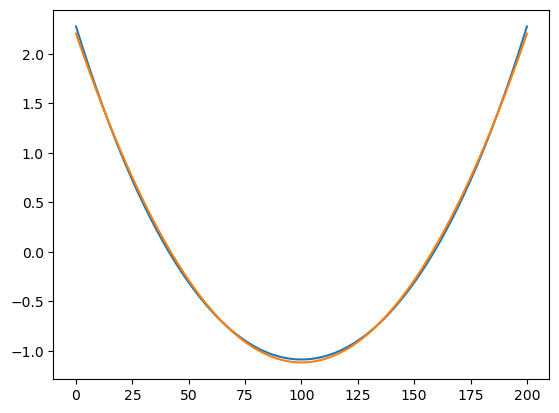

In [166]:
# compare the standard det
plt.plot((det_L_record-np.mean(det_L_record))/np.std(det_L_record))
plt.plot((det_ML_inv-np.mean(det_ML_inv))/np.std(det_ML_inv))

In [7]:
np.shape(x_predictor)

NameError: name 'x_predictor' is not defined